In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder

Let's read the first dataset that we have:

In [3]:
combined_df = pd.read_csv("data/property_prices_combined.csv")

And review it:

In [4]:
combined_df

,Район,Цена,Цена / кв.м.,Валута,Тип Апартамент,Дата
0,Банишора,134653.98,1987.51,EUR,Двустаен апартамент,2024-07-28
1,Банкя (гр.),131843.00,1890.84,EUR,Двустаен апартамент,2024-07-28
2,Белите Брези,249900.00,2108.86,EUR,Двустаен апартамент,2024-07-28
3,Бенковски,115863.50,1782.52,EUR,Двустаен апартамент,2024-07-28
4,Борово,135594.22,2148.50,EUR,Двустаен апартамент,2024-07-28
...,...,...,...,...,...,...
4419,Стрелбище,175333.00,1075.67,EUR,Многостаен апартамемент,2021-07-28
4420,Студентски Град,222600.00,718.84,EUR,Многостаен апартамемент,2021-07-28
4421,Хаджи Димитър,205000.00,1045.92,EUR,Многостаен апартамемент,2021-07-28
4422,Хиподрума,330000.00,2357.14,EUR,Многостаен апартамемент,2021-07-28


Let's normalize the titles like convert the column names from Bulgarian to English:

In [5]:
combined_df = combined_df.rename(columns={
    'Район': 'region',
    'Цена': 'price',
    'Цена / кв.м.': 'price_per_sqm',
    'Валута': 'currency',
    'Тип Апартамент': 'apartment_type',
    'Дата': 'date'
})


combined_df.head()

,region,price,price_per_sqm,currency,apartment_type,date
0,Банишора,134653.98,1987.51,EUR,Двустаен апартамент,2024-07-28
1,Банкя (гр.),131843.00,1890.84,EUR,Двустаен апартамент,2024-07-28
2,Белите Брези,249900.00,2108.86,EUR,Двустаен апартамент,2024-07-28
3,Бенковски,115863.50,1782.52,EUR,Двустаен апартамент,2024-07-28
4,Борово,135594.22,2148.50,EUR,Двустаен апартамент,2024-07-28


#### Let's take a closer look at the dataset.

In [6]:
combined_df.shape

(4424, 6)

It has 4424 observations and 6 features.

In [7]:
combined_df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,4424.0,240272.109042,257381.183834,6500.0,110658.525,164470.080,266816.71,3000000.0
price_per_sqm,4424.0,1807.489643,681.901018,17.4,1421.750,1721.535,2096.62,17750.0


In [8]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   region          4424 non-null   object 
 1   price           4424 non-null   float64
 2   price_per_sqm   4424 non-null   float64
 3   currency        4424 non-null   object 
 4   apartment_type  4424 non-null   object 
 5   date            4424 non-null   object 
dtypes: float64(2), object(4)
memory usage: 207.5+ KB


In [9]:
combined_df.dtypes

region             object
price             float64
price_per_sqm     float64
currency           object
apartment_type     object
date               object
dtype: object

Let's convert the "date" column in the correct data type:

In [10]:
combined_df["date"] = pd.to_datetime(combined_df["date"])

Check the converted format:

In [11]:
combined_df["date"]

0      2024-07-28
1      2024-07-28
2      2024-07-28
3      2024-07-28
4      2024-07-28
          ...    
4419   2021-07-28
4420   2021-07-28
4421   2021-07-28
4422   2021-07-28
4423   2021-07-28
Name: date, Length: 4424, dtype: datetime64[ns]

Check for NaN values:

In [12]:
combined_df.isna().sum()

region            0
price             0
price_per_sqm     0
currency          0
apartment_type    0
date              0
dtype: int64

We don't have null values in this dataset.

Let's see how many __unique Ragions__ we have:

In [13]:
len(combined_df['region'].unique())

103

And which they are:

In [14]:
combined_df['region'].unique()

array(['Банишора', 'Банкя (гр.)', 'Белите Брези', 'Бенковски', 'Борово',
       'Бояна', 'Бъкстон', 'Витоша', 'Гевгелийски', 'Гео Милев',
       'Горна Баня', 'Гоце Делчев', 'Дианабад', 'Драгалевци', 'Дружба',
       'Дружба 1', 'Дружба 2', 'Дървеница', 'Западен Парк',
       'Захарна Фабрика', 'Зона Б18', 'Зона Б19', 'Зона Б5', 'Иван Вазов',
       'Изгрев', 'Изток', 'Илинден', 'Княжево', 'Красна Поляна',
       'Красно Село', 'Кръстова Вада', 'Лагера', 'Левски', 'Левски В',
       'Левски Г', 'Лозенец', 'Люлин 1', 'Люлин 10', 'Люлин 2', 'Люлин 3',
       'Люлин 4', 'Люлин 5', 'Люлин 6', 'Люлин 7', 'Люлин 8', 'Люлин 9',
       'Люлин Център', 'м-т Гърдова глава', 'Малинова Долина',
       'Малинова долина в.з.', 'Манастирски ливади Запад',
       'Манастирски ливади Изток', 'Младост 1', 'Младост 1а', 'Младост 2',
       'Младост 3', 'Младост 4', 'Мотописта', 'Мусагеница', 'Надежда 1',
       'Надежда 2', 'Надежда 3', 'Надежда 4', 'Обеля', 'Обеля 1',
       'Обеля 2', 'Оборище', 'Овча 

How many property types we have and which are thay?

In [15]:
len(combined_df['apartment_type'].unique())

6

In [16]:
combined_df['apartment_type'].unique()

array(['Двустаен апартамент', 'Тристаен апартамент', 'Къща',
       'Гараж, паркомясто', 'Ателие, таван, студио',
       'Многостаен апартамемент'], dtype=object)

In [17]:
combined_df.columns

Index(['region', 'price', 'price_per_sqm', 'currency', 'apartment_type',
       'date'],
      dtype='object')

__What are the mean prices by apartment type and date?__

In [18]:
mean_prices = combined_df.groupby(['apartment_type', 'date'])['price'].mean()

print(mean_prices)

apartment_type         date      
Ателие, таван, студио  2021-07-28     77116.214286
                       2022-01-10     94700.741111
                       2022-07-28    105442.089231
                       2022-11-19    109510.400000
                       2023-01-10    110105.194444
                                         ...      
Тристаен апартамент    2024-03-12    214684.272444
                       2024-04-13    215648.782135
                       2024-05-15    216724.884205
                       2024-06-20    220292.982921
                       2024-07-28    220629.843371
Name: price, Length: 84, dtype: float64


__What are the median prices by apartment type and date?__

In [19]:
median_prices = combined_df.groupby(['apartment_type', 'date'])['price'].median()
print(median_prices)

apartment_type         date      
Ателие, таван, студио  2021-07-28     69866.50
                       2022-01-10     79990.00
                       2022-07-28     99400.00
                       2022-11-19     89664.50
                       2023-01-10     71500.00
                                       ...    
Тристаен апартамент    2024-03-12    194120.96
                       2024-04-13    199763.42
                       2024-05-15    202096.90
                       2024-06-20    209206.14
                       2024-07-28    209953.33
Name: price, Length: 84, dtype: float64


In [20]:
# # Average Price per Square Meter Over Time for Each Apartment Type
# avg_price_per_sqm = combined_df.groupby(['date', 'apartment_type'])['price_per_sqm'].mean().unstack()

# avg_price_per_sqm.plot(figsize=(12, 8))
# plt.title('Average Price per Square Meter Over Time')
# plt.xlabel('Date')
# plt.ylabel('Price per Square Meter (EUR)')
# plt.show()


__What are the most expensive regions for each apartment type?__

In [21]:
# Group by 'apartment_type' and 'region' and calculate the mean price
grouped = combined_df.groupby(['apartment_type', 'region', 'date'])['price'].mean().reset_index()

# Sort within each apartment type to find the most and least expensive regions
most_expensive = grouped.groupby('apartment_type').apply(lambda x: x.nlargest(1, 'price')).reset_index(drop=True)

# Display the results
print("Most Expensive Regions for Each Apartment Type:")
print(most_expensive)

Most Expensive Regions for Each Apartment Type:
            apartment_type                region       date      price
0    Ателие, таван, студио             Младост 3 2023-07-28   295560.0
1        Гараж, паркомясто              Зона Б18 2024-02-11   355000.0
2      Двустаен апартамент               Люлин 4 2022-01-10   492000.0
3                     Къща       Студентски Град 2023-07-28  3000000.0
4  Многостаен апартамемент            Иван Вазов 2023-01-10  2000000.0
5      Тристаен апартамент  Малинова долина в.з. 2023-01-10   591181.0


__What are the least expensive regions for each apartment type?__

In [22]:
# Sort within each apartment type to find the most and least expensive regions
least_expensive = grouped.groupby('apartment_type').apply(lambda x: x.nsmallest(1, 'price')).reset_index(drop=True)

print("\nLeast Expensive Regions for Each Apartment Type:")
print(least_expensive)


Least Expensive Regions for Each Apartment Type:
            apartment_type          region       date    price
0    Ателие, таван, студио         Люлин 4 2021-07-28  15000.0
1        Гараж, паркомясто          Редута 2022-07-28   6500.0
2      Двустаен апартамент  Фондови Жилища 2021-07-28  38000.0
3                     Къща    Западен Парк 2023-07-28  97500.0
4  Многостаен апартамемент         Люлин 6 2022-01-10  55100.0
5      Тристаен апартамент         Люлин 4 2021-07-28  71000.0


__Which year had the most expensive property prices?__

In [23]:
combined_df['year'] = combined_df['date'].dt.year

# Group by 'year' and calculate the average price per year
avg_price_per_year = combined_df.groupby('year')['price'].mean()

# Find the year with the highest average price
most_expensive_year = avg_price_per_year.idxmax()
highest_avg_price = avg_price_per_year.max()

print(f"The year with the most expensive prices is {most_expensive_year} with an average price of {highest_avg_price:.2f} EUR.")

print(avg_price_per_year)

The year with the most expensive prices is 2024 with an average price of 252617.46 EUR.
year
2021    173249.537153
2022    225958.331726
2023    243816.700261
2024    252617.457486
Name: price, dtype: float64


The answear is __2024__. As we can see, prices have been increasing.

__How much the price per square meter increases each year for different types of apartments?__

In [24]:
# Group by Year and Apartment Type and calculate the mean price per square meter
avg_price_per_sqm_by_year = combined_df.groupby(['year', 'apartment_type'])['price_per_sqm'].mean().reset_index()

# Calculate the yearly increase
avg_price_per_sqm_by_year['yearly_increase'] = avg_price_per_sqm_by_year.groupby('apartment_type')['price_per_sqm'].diff()

avg_price_per_sqm_by_year

,year,apartment_type,price_per_sqm,yearly_increase
0,2021,"Ателие, таван, студио",1242.373571,NaN
1,2021,"Гараж, паркомясто",906.384375,NaN
2,2021,Двустаен апартамент,1334.757586,NaN
3,2021,Къща,1506.022143,NaN
4,2021,Многостаен апартамемент,1364.870244,NaN
5,2021,Тристаен апартамент,1281.000814,NaN
6,2022,"Ателие, таван, студио",1610.543750,368.170179
7,2022,"Гараж, паркомясто",1103.260366,196.875991
8,2022,Двустаен апартамент,1672.473745,337.716159
9,2022,Къща,1818.250917,312.228775


For $2021$, there's no $2020$ data available to subtract from. So, the calculation $2021$ price - (no data) results in $NaN$.

### Let's plot the prices over time for each apartment type:

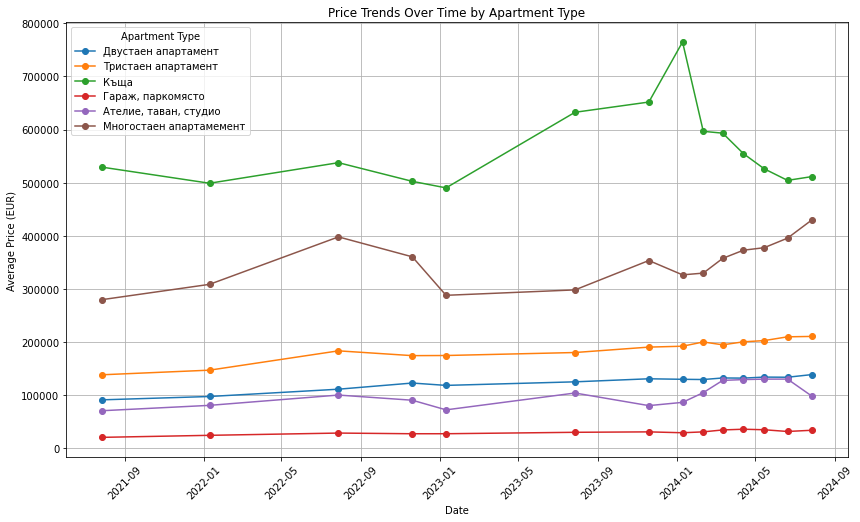

In [25]:
apartment_types = combined_df["apartment_type"].unique()

plt.figure(figsize=(14, 8))

for apartment_type in apartment_types:
    # Filter the DataFrame by apartment type
    filtered_df = combined_df[combined_df["apartment_type"] == apartment_type]
    
    # Group by date and calculate the mean price for each date
    price_over_time = filtered_df.groupby('date')['price'].median()
    
    # Plot the line for this apartment type
    plt.plot(price_over_time.index, price_over_time.values, marker='o', label=apartment_type)

plt.title('Price Trends Over Time by Apartment Type')
plt.xlabel('Date')
plt.ylabel('Average Price (EUR)')
plt.xticks(rotation=45)
plt.legend(title='Apartment Type')
plt.grid(True)
plt.show()

### Identify Outliers

In [26]:
# from scipy import stats

# combined_df['z_score'] = stats.zscore(combined_df['price_per_sqm'])
# outliers = combined_df[combined_df['z_score'].abs() > 3]
# outliers

In [27]:
# combined_df = combined_df[combined_df['z_score'].abs() <= 3].copy()

In [28]:
combined_df.shape

(4424, 7)

In [29]:
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# List of columns to check for outliers
columns_to_check = ['price', 'price_per_sqm']

# Find outliers for each column
outliers_dict = {col: find_outliers(combined_df, col) for col in columns_to_check}
outliers_dict

# Combine all outliers into a single DataFrame
all_outliers = pd.concat(outliers_dict.values()).drop_duplicates()

# Remove outliers from the original DataFrame
combined_df = combined_df[~combined_df.index.isin(all_outliers.index)]


In [30]:
combined_df.shape

(3866, 7)

### Plot the prices over time for each apartment type with removed outliers

In [31]:
# combined_df = combined_df[(combined_df['price_per_sqm'] >= lower_bound) & (combined_df['price_per_sqm'] <= upper_bound)].copy()

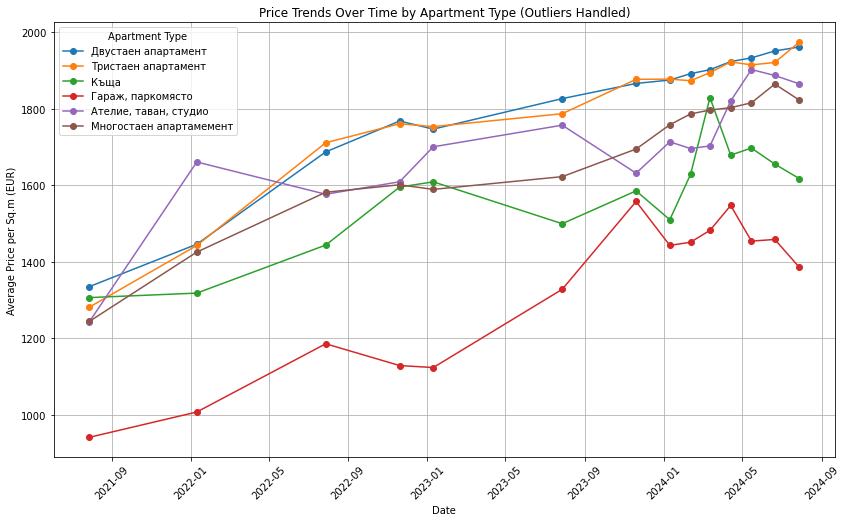

In [32]:
plt.figure(figsize=(14, 8))

for apartment_type in combined_df['apartment_type'].unique():
    filtered_df = combined_df[combined_df['apartment_type'] == apartment_type]
    price_over_time = filtered_df.groupby('date')['price_per_sqm'].mean()
    plt.plot(price_over_time.index, price_over_time.values, marker='o', label=apartment_type)

plt.title('Price Trends Over Time by Apartment Type (Outliers Handled)')
plt.xlabel('Date')
plt.ylabel('Average Price per Sq.m (EUR)')
plt.xticks(rotation=45)
plt.legend(title='Apartment Type')
plt.grid(True)
plt.show()

In [33]:
# scaler = StandardScaler()
# combined_df[['price', 'price_per_sqm', 'year']] = scaler.fit_transform(combined_df[['price', 'price_per_sqm', 'year']])


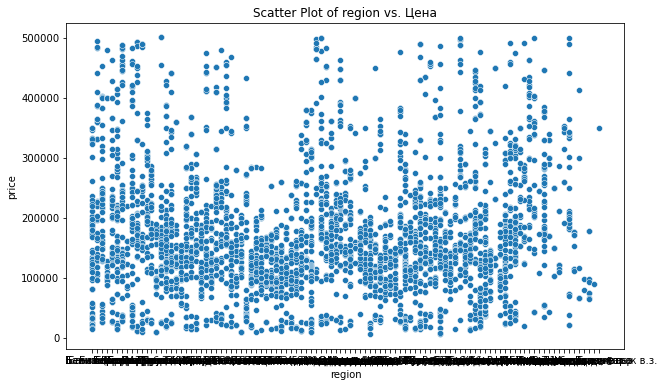

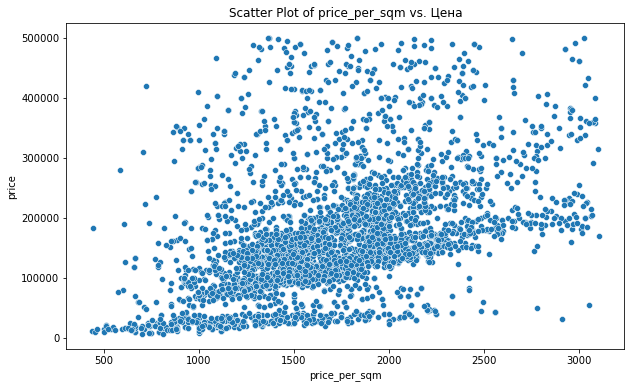

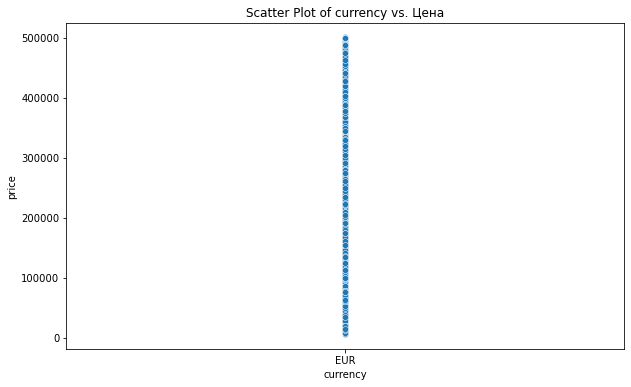

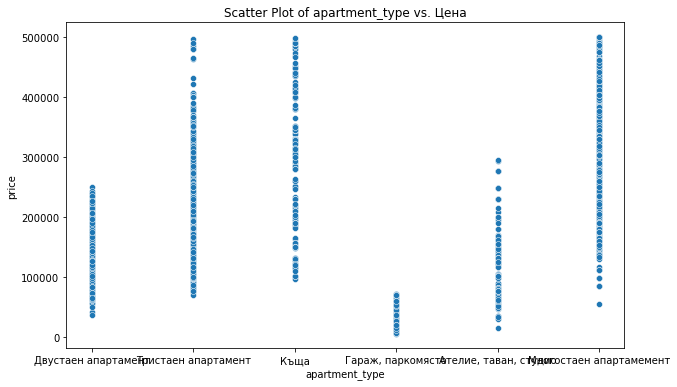

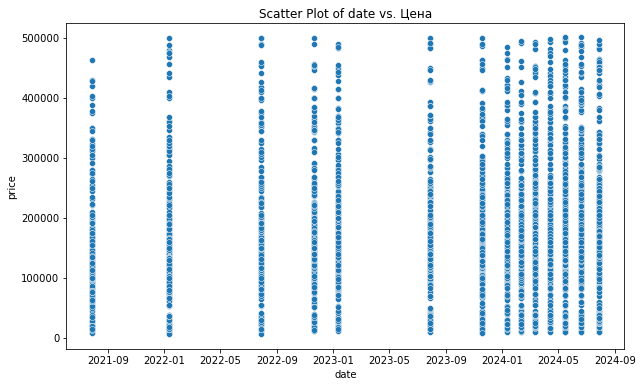

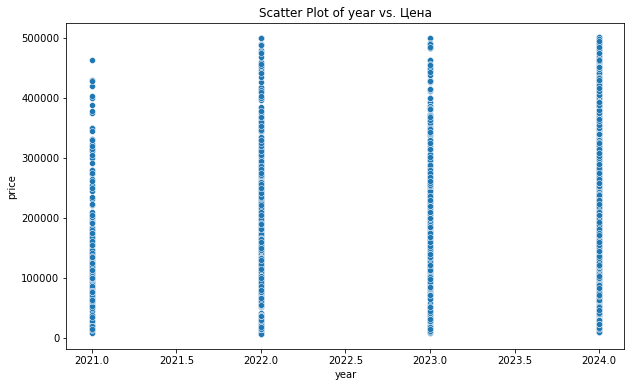

In [34]:
# Scatter plots for each independent variable vs. dependent variable
independent_vars = [col for col in combined_df.columns if col != 'price']
for var in independent_vars:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=combined_df[var], y=combined_df['price'])
    plt.title(f'Scatter Plot of {var} vs. Цена')
    plt.xlabel(var)
    plt.ylabel('price')
    plt.show()


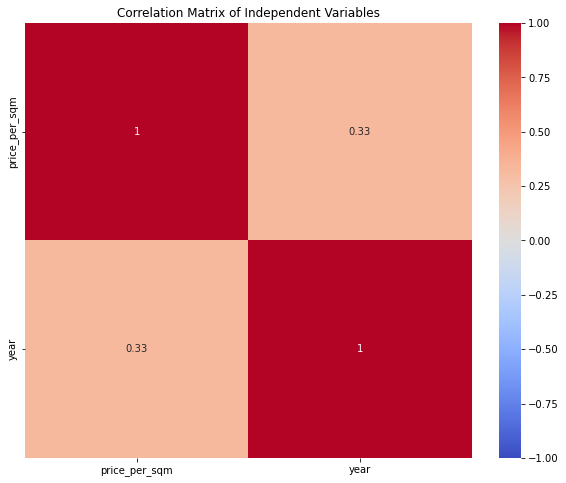

In [35]:
# Calculate correlation matrix
correlation_matrix = combined_df[independent_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Independent Variables')
plt.show()


In [36]:
# List of independent variables
independent_vars = ['region', 'price_per_sqm', 'currency', 'apartment_type', 'year']

# Calculate correlation matrix
correlation_matrix = combined_df[independent_vars].corr()

# Display the correlation matrix
print("Correlation Matrix of Independent Variables:")
print(correlation_matrix)

Correlation Matrix of Independent Variables:
               price_per_sqm      year
price_per_sqm       1.000000  0.325653
year                0.325653  1.000000


In [37]:
# # Boxplot to show price_per_sqm distribution across regions
# plt.figure(figsize=(20, 10))
# sns.boxplot(x='region', y='price_per_sqm', data=combined_df)
# plt.title('Price per Square Meter by Region')
# plt.show()


# Let's prepear the model and train it:

Extract date features:

In [38]:
combined_df['year'] = combined_df['date'].dt.year
combined_df['month'] = combined_df['date'].dt.month

Drop the original 'Дата' column and unnecessary columns:

In [39]:
combined_df = combined_df.drop(columns=['date', 'currency', 'price'])

In [40]:
combined_df

,region,price_per_sqm,apartment_type,year,month
0,Банишора,1987.51,Двустаен апартамент,2024,7
1,Банкя (гр.),1890.84,Двустаен апартамент,2024,7
2,Белите Брези,2108.86,Двустаен апартамент,2024,7
3,Бенковски,1782.52,Двустаен апартамент,2024,7
4,Борово,2148.50,Двустаен апартамент,2024,7
...,...,...,...,...,...
4418,Слатина,900.00,Многостаен апартамемент,2021,7
4419,Стрелбище,1075.67,Многостаен апартамемент,2021,7
4420,Студентски Град,718.84,Многостаен апартамемент,2021,7
4421,Хаджи Димитър,1045.92,Многостаен апартамемент,2021,7


Encode categorical variables:

In [41]:
label_encoder_region = LabelEncoder()
label_encoder_apartment_type = LabelEncoder()

combined_df['region'] = label_encoder_region.fit_transform(combined_df['region'])
combined_df['apartment_type'] = label_encoder_apartment_type.fit_transform(combined_df['apartment_type'])

I tested the performance of the model with OneHot encoding, but it was slightly better with LabelEncoder.

In [42]:
# encoder_region = OneHotEncoder(sparse=False)
# encoder_apartment_type = OneHotEncoder(sparse=False)

# combined_df['region'] = encoder_region.fit_transform(combined_df[['region']])
# combined_df['apartment_type'] = encoder_apartment_type.fit_transform(combined_df[['apartment_type']])

Define features and target:

In [43]:
X = combined_df.drop(columns=['price_per_sqm'], axis=1) 
y = combined_df['price_per_sqm']  # Target variable


In [44]:
X

,region,apartment_type,year,month
0,2,2,2024,7
1,3,2,2024,7
2,4,2,2024,7
3,5,2,2024,7
4,6,2,2024,7
...,...,...,...,...
4418,86,4,2021,7
4419,87,4,2021,7
4420,88,4,2021,7
4421,95,4,2021,7


Split the data into training and testing sets:

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
X_train

,region,apartment_type,year,month
2539,61,1,2023,11
473,54,5,2024,6
3499,76,1,2022,11
249,65,1,2024,7
1039,49,2,2024,4
...,...,...,...,...
1323,96,4,2024,4
1499,87,5,2024,3
1009,18,2,2024,4
4019,95,5,2022,1


In [47]:
y_train

2539    1120.00
473     2475.51
3499     825.65
249      735.29
1039    1586.99
         ...   
1323    1574.36
1499    2354.14
1009    1596.70
4019    1344.86
3656     876.43
Name: price_per_sqm, Length: 3092, dtype: float64

In [48]:
X_train.shape, y_test.shape

((3092, 4), (774,))

In [49]:
X_test.shape, y_train.shape

((774, 4), (3092,))

## Train the model

In [50]:
model = LinearRegression()

In [51]:
model.fit(X_train, y_train)

LinearRegression()

## Prediction results

In [52]:
y_pred = model.predict(X_test)

In [53]:
y_pred

array([1660.99066302, 1759.55485004, 1615.88572102, 1873.42299417,
       1922.68733967, 1569.32819563, 1879.42079502, 1943.77535736,
       1827.18577904, 1647.90598099, 1735.1953046 , 1727.56173987,
       1409.1246126 , 1860.33204428, 1854.87949805, 1659.35489915,
       1874.33175187, 1639.89637746, 1846.81978441, 1690.10289833,
       1830.68082221, 1464.24534237, 1692.6474199 , 1788.12666965,
       1661.3541661 , 1850.81831831, 1953.77653105, 1873.38749814,
       1734.98289596, 1558.42310317, 1711.72363492, 1547.73041934,
       1920.48543923, 1835.9516169 , 1828.27628829, 1954.50353722,
       1736.64931693, 1863.0583174 , 1315.68639369, 1746.43324305,
       1670.6234947 , 1759.19761482, 1893.7840057 , 1868.29845499,
       1578.63928812, 1798.62506621, 1525.85901751, 1566.05666789,
       1851.58708836, 1751.73953377, 1617.01942309, 1743.93048536,
       1827.0040275 , 1684.13575457, 1753.73880072, 1884.8364163 ,
       1626.60906195, 1872.29072104, 1714.44990804, 1773.91806

## Make predictions

In [54]:
# Example: Predicting for 2025 with specific assumptions for features
future_data = {
    'region': label_encoder_region.transform(['Банишора', 'Белите Брези']),  # Encode regions
    'apartment_type': label_encoder_apartment_type.transform(['Двустаен апартамент', 'Тристаен апартамент']),  # Encode apartment types
    'year': [2025] * 2,  # Assuming 2 predictions for example purposes
    'month': [1, 1],  # Predicting for January 2025
}

# Convert to DataFrame
future_X = pd.DataFrame(future_data)

# Make predictions
future_predictions = model.predict(future_X)

In [55]:
# Decode the encoded labels back to their original strings
decoded_regions = label_encoder_region.inverse_transform(future_data['region'])
decoded_apartment_types = label_encoder_apartment_type.inverse_transform(future_data['apartment_type'])

# Display predictions with original labels
for i, prediction in enumerate(future_predictions):
    region_label = decoded_regions[i]
    apartment_type_label = decoded_apartment_types[i]
    print(f"Prediction for {region_label} - {apartment_type_label}: {prediction:.2f} per square meter")

Prediction for Банишора - Двустаен апартамент: 1920.48 per square meter
Prediction for Белите Брези - Тристаен апартамент: 2047.80 per square meter


## Evaluate the model

In [56]:
cdf = pd.DataFrame(model.coef_, X.columns, columns=['coefficients'])
cdf

,coefficients
region,-0.181752
apartment_type,42.560420
year,177.832054
month,18.543496


In [57]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [58]:
print("Coefficients:", *model.coef_)
print("Intercept:", model.intercept_)
print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print(f"Mean squared error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Coefficient of determination (R^2): {r2_score(y_test, y_pred):.2f}")

Coefficients: -0.18175154112070038 42.560420419212335 177.83205358285 18.543496121424504
Intercept: -358292.7301677822
Mean Absolute Error:  336.67435230554867
Mean squared error (MSE): 189613.56
Root Mean Squared Error: 435.45
Coefficient of determination (R^2): 0.16


## Residuals

In [59]:
residuals = y_test - y_pred

In [60]:
residuals

2699     32.959337
1667    142.065150
2880   -495.695721
1835    565.237006
1103   -158.937340
           ...    
2625    193.124468
4061      6.304416
2848   -123.698105
3242   -479.065049
796    -569.035296
Name: price_per_sqm, Length: 774, dtype: float64

__Residuals help identify patterns in the prediction errors.__

In [61]:
combined_df.columns

Index(['region', 'price_per_sqm', 'apartment_type', 'year', 'month'], dtype='object')

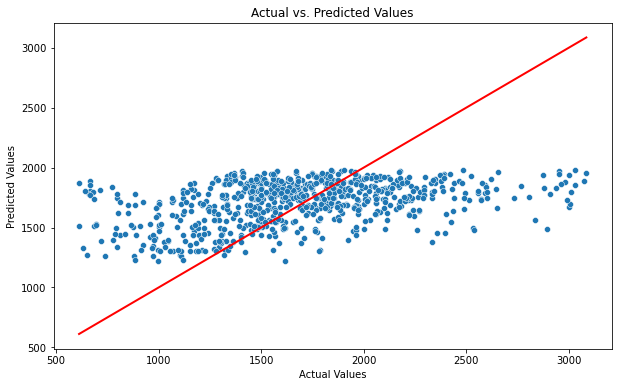

In [62]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.show()

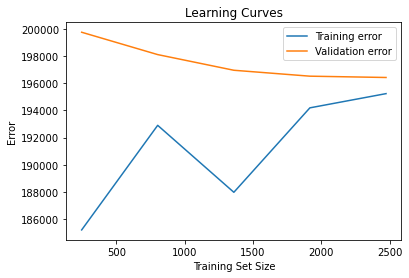

In [63]:
train_sizes, train_scores, validation_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'
)

train_errors_mean = -train_scores.mean(axis=1)
validation_errors_mean = -validation_scores.mean(axis=1)

plt.plot(train_sizes, train_errors_mean, label='Training error')
plt.plot(train_sizes, validation_errors_mean, label='Validation error')
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.title('Learning Curves')
plt.legend()
plt.show()

- High Bias (Underfitting): If both training and validation errors are high and similar, the model might be too simple and underfitting the data.
- High Variance (Overfitting): If the training error is much lower than the validation error, and the validation error is high, the model might be too complex and overfitting the data.

#### Cross-Validation

In [64]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-Validation Scores: {-scores.mean()} ± {scores.std()}')

Cross-Validation Scores: 196411.33813938955 ± 9700.57892904975


## Conclusion

__In this project, I conducted a comprehensive analysis and modeling exercise on the dataset, focusing on understanding the data structure, relationships, and ultimately building a predictive model.__


Data Exploration and Preprocessing:
I started with exploratory data analysis (EDA) to identify patterns, trends, and potential issues such as missing values and outliers.
Data preprocessing steps included handling missing values, encoding categorical variables, and feature scaling to ensure that the data was suitable for modeling.

Modeling and Evaluation:
Multiple machine learning models were trained and evaluated, with performance metrics indicating varying degrees of success.
The model evaluation included metrics like Mean Squared Error (MSE), which helped gauge the model's accuracy.
Cross-validation was used to ensure that the model's performance was consistent across different subsets of the data, reducing the likelihood of overfitting

Learning Curves Analysis:
I examined the learning curves to diagnose the model’s bias-variance trade-off. This analysis revealed whether the model was underfitting or overfitting the data.

__Overall, this project provides a solid foundation for predictive modeling, with clear pathways for further refinement and enhancement of the model's accuracy and generalizability.__

